In [ ]:
# Импортируем необходимые библиотеки

In [ ]:
import math
import time
import dearpygui.dearpygui as dpg
import menu_defs as md
import other_defs as od
import forms_recognition as fm
import areas_math as am
import cv2
import os.path
import win32api
import pandas as pd
from tkinter import messagebox, filedialog
from threading import Thread

In [ ]:
# Объявляем главные переменные

In [ ]:
circles_count = 0  # Кол-во найденных круглых частиц
elipses_count = 0  # Кол-во найденных элипсоидных частиц
triangles_count = 0  # Кол-во найденных треугольных частиц
squares_count = 0  # Кол-во найденных квадратных частиц
pentagon_count = 0  # Кол-во найденных пятиугольных частиц
hexagonal_count = 0  # Кол-во найденных шестиугольных частиц
heptagon_count = 0  # Кол-во найденных семиугольных частиц
octagon_count = 0  # Кол-во найденных восьмиугольных частиц
nonagon_count = 0  # Кол-во найденных девятиугольных частиц
decagon_count = 0  # Кол-во найденных десятиугольных частиц
other_count = 0  # Кол-во остальных найденных частиц

circles_tag = 0  # Счётчик кругов отмеченных вручную (нужен для сброса выделения)
amorphous_tag = 0  # Счётчик других фигур отмеченных вручную (нужен для сброса выделения)

scale_px = 0  # Масштаб в пикселях
scale_num = 0  # Масштаб в дольной единице
scale_type = "nm"  # Тип дольной единицы
scale_size = 0  # Соотношение масштаба в пикселях к масштабу единицы

main_width = 800  # Длина окна
main_height = 600  # Высота окна
win_width = 0  # Длина окна со статистикой и изображением
img_size = 0  # Размер изображения

circles_areas = []  # Список площадей круглых форм
circles_diameters = []  # Список диаметров круглых форм
elipses_areas = []  # Список площадей эллипсоидных форм
elipses_diameters = []  # Список диаметров эллипсоидных форм

triangles_areas = []  # Список площадей треугольных форм
squares_diameters = []  # Список плошадей квадратных форм
pentagon_areas = []  # Список площадей пятиугольных форм
hexagonal_areas = []  # Список площадей шестиугольных форм
heptagon_areas = []  # Список площадей семиугольных форм
octagon_areas = []  # Список площадей восьмиугольных форм
nonagon_areas = []  # Список площадей девятиугольных форм
decagon_areas = []  # Список площадей десятиугольных форм
other_areas = []  # Список площадей аморфных форм

scale_px = 0  # Масштаб в пикселях
scale_num = 0  # Масштаб в дольной единице
scale_type = "nm"  # Тип дольной единицы
scale_size = 0  # Соотношение масштаба в пикселях к дольной единице

main_width = 800  # Длина окна
main_height = 600  # Высота окна
win_width = 0  # Длина окна со статистикой и изображением
img_size = 0  # Размер изображения

In [ ]:
# Функция отрисовки интерфейса программы

Данная функция предназначена для отрисовки главного окна с подсказкой, а также меню-бара

In [ ]:
def gui_init():
    dpg.create_context()  # Создание окружения

    dpg.create_viewport(title='APR', width=main_width,
                        height=main_height)  # Создаём ViewPort; Задаём параметры окна

    with dpg.viewport_menu_bar():  # Создаём меню-бар
        with dpg.menu(label="File"):  # Создаём кнопку "Файл" в меню-баре
            dpg.add_menu_item(label="Load Photo", callback=load_image)  # Добавляем кнопку для загрузки фото
            dpg.add_menu_item(label="Close Photo", callback=close_image)  # Добавляем кнопку для закрытия фото
            dpg.add_menu_item(label="Exit", callback=md.exit_app)  # Добавляем кнопку для выхода из программы

    '''Создаём базовое окно с подсказкой при запуске программы'''

    with dpg.window(tag="main_win"):
        dpg.add_text(default_value="Please Load a Photo...", tag="help_text",
                     pos=[(main_width // 2) - 80, (main_height // 2) - 20])  # Добавляем текст подсказки; Устанавливаем текст по центру

In [ ]:
# Функция для изменения размера подсказки при изменении размера окна

In [ ]:
def resize_win(sender, data):
    global main_width, main_height  # Глобализуем переменные длины и высоты
    main_width = data[2]  # Получаем длину окна
    main_height = data[3]  # Получаем высоту окна
    dpg.configure_item("help_text", pos=[(main_width // 2) - 80, (main_height // 2) - 20])  # Центрируем подсказку в соответствии со заданным размером окна

In [ ]:
# Функция для загрузки изображения

In [ ]:
def load_image():
    global win_width, img_size  # Глобализуем переменные длины окна и размера изображения
    img_path = md.load_photo()  # Создаём диалоговое окно для загрузки (модуль menu_defs)

    if img_path != "":  # Если путь не пустой
        dpg.delete_item("Color Sensitivity")  # Удаляем окно фильтрации по цвету
        dpg.delete_item("Image_WIN")  # Удаляем окно изображения
        dpg.delete_item("texture_tag")  # Удаляем текстуру изображения
        dpg.configure_item("main_win", show=True)  # Делаем окно с подсказкой невидимым

    od.clean_tmp()  # Очищаем папку с временными файлами (модуль other_defs)

    img = cv2.imread(img_path)  # Чтение изображения с помощью OpenCV

    width = img.shape[1]  # Получаем длину изображения
    height = img.shape[0]  # Получаем высоту изображения

    img_size = width * height  # Получаем масштаб изображения путём умножения длины на высоту (нужен для вычисления размеров частиц)

    if width > 800 or height > 800:  # Если изображение больше чем 800x800
        win_width = (width // 2) + 18  # Делим его длину на два, чтобы изображение не растягивалось на весь экран
        win_height = (height // 2) + 60  # Делим его высоту на два, чтобы изображение не растягивалось на весь экран
        statistic_pos = [0, win_height + 18]  # Указываем позицию окна с выводом статистики

        dsize = (width // 2, height // 2)  # Создаём кортеж с длиной и высотой изображения, чтобы изменить его размер через OpenCV
    else:
        win_width = width + 65  # Если изображение меньше чем 800x800, добавляем 65 пикселей к длине окна
        win_height = height + 60  # Прибавляем 60 пикселей к высоте окна
        statistic_pos = [0, win_height + 60]  # Указываем позицию окна с выводом статистики

        dsize = (width, height)  # Создаём кортеж с длиной и высотой изображения

    new_img = cv2.resize(img, dsize=dsize)  # Меняем размер изображения

    cv2.imwrite("tmp//load_image.jpg", new_img)  # Сохраняем его во временную папку

    try:
        width, height, channels, data = dpg.load_image("tmp//load_image.jpg")  # Пытаемся прочитать изображение
    except TypeError:
        md.load_photo_err()  # В случае ошибки, выводим сообщение об этом
        return

    dpg.configure_item("main_win", show=False)  # Делаем окно с подсказкой невидимым

    with dpg.texture_registry(show=False):  # Загружаем изображение в DPG как текстуру
        dpg.add_dynamic_texture(width=width, height=height, default_value=data, tag="texture_tag")

    '''Создаём окно в котором будет находится изображение'''

    with dpg.window(label="Image", width=win_width, height=win_height, no_resize=True, tag="Image_WIN", no_close=True):
        dpg.add_image("texture_tag", tag="Image")  # Добавляем изображение
        with dpg.group(horizontal=True):  # Создаём группу элементов
            dpg.add_button(label="Highlight Automatically", callback=find_automatically)  # Кнопка для автоматического поиска частиц
            dpg.add_button(label="Select manually", callback=select_manually)  # Кнопка для ручного поиска частиц
            dpg.add_button(label="Build Graph", callback=table_win)  # Кнопка построения графика
            dpg.add_button(label="Scale Settings", callback=find_scale)  # Кнопка для настройки масштаба
            dpg.add_button(label="Reset", callback=reset_highlight)  # Кнопка для сброса выделения

        dpg.draw_line((100, 60), (50, 60), color=(255, 0, 0, 255), tag="line", show=False)  # Создаём линию. Делаем её невидимой

    statistic_win(statistic_pos)  # Добавляем окно со статистикой

    '''Создаём окно для регулировки чувствительности цвета'''

    with dpg.window(tag="Color Sensitivity", label="Color Sensitivity", width=300,
                    height=350, pos=[win_width - 1, 0], no_close=True):
        dpg.add_color_picker(tracked=True)  # Добавляем цветовую палитру

        with dpg.group(horizontal=True):  # Создаём группу элментов, для расположения их по горизонтали
            dpg.add_text(default_value="From:")  # Добавляем текст с подсказкой
            dpg.add_input_text(tag="min_color")  # Добавляем поле для ввода минимального значения цвета

        with dpg.group(horizontal=True):  # Создаём группу элментов, для расположения их по горизонтали
            dpg.add_text(default_value="To:")  # Добавляем текст с подсказкой
            dpg.add_input_text(tag="max_color")  # Добавляем поле для ввода максимального значения цвета

        with dpg.group(horizontal=True):  # Создаём группу элментов, для расположения их по горизонтали
            dpg.add_button(label="Apply", callback=filter_image)  # Добавляем кнопку фильтрации
            dpg.add_button(label="Reset", callback=reset_image)  # Добавляем кнопку сброса фильтра

In [ ]:
# Функция для закрытия изображения

In [ ]:
def close_image():
    answer = messagebox.askokcancel(title="Вы уверены?",
                                    message="Вы уверены что хотите закрыть изображение?")  # Окно с вопросом

    '''Если пользователь уверен, закрываем все окна и возвращаем главное окно'''

    if answer:
        dpg.delete_item("Color Sensitivity")  # Закрываем окно цветового фильтра
        dpg.delete_item("Image_WIN")  # Закрываем изображение
        dpg.delete_item("texture_tag")
        dpg.delete_item("Statistic")  # Закрываем окно со статистикой
        dpg.configure_item("main_win", show=True)  # Делаем стартовое окно снова видимым


Для поиска площадей частиц используется модуль areas_math (файл areas_math.py). Далее представлен его исходный код:

In [ ]:
# Импорт необходимых модулей
import math


# Функция для поиска плоащди треугольника


def triangle_square(perimeter):
    a = perimeter / 3  # Вычисляем длину каждой стороны треугольника путём разделения периметра на три части
    area = (3 ** 0.5) / 4 * a ** 2  # Вычисляем площадь треугольника с помощью формулы

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади четырёхугольника


def square_area(a, b, c, d):
    p = a + b + c + d  # Вычисляем периметр четырёхугольника
    s = p / 2  # Вычисляем полупериметр четырёхугольника
    area = (s - a) * (s - b) * (s - c) * (s - d)  # Вычисляем плоащадь через формулу Герона

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади пятиугольника


def pentagon_area(perimeter):
    side_length = perimeter / 5  # Получаем длину каждой стороны путём разделения периметра на 5
    apothem = side_length / (2 * math.tan(math.pi / 5))  # Получаем апофему с помощью формулы
    area = (5 * side_length * apothem) / 2  # Вычисляем площадь

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади шестиугольника


def hexagonal_area(perimeter):
    side_length = perimeter / 6  # Получаем сторону шестиугольника путём разделения периметра на 6
    apothem_length = side_length * 3**0.5 / 2  # Вычисляем апофему с помощью формулы
    area = apothem_length * perimeter / 2  # Вычисляем площадь

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади семиугольника


def heptagon_area(perimeter):
    side_length = perimeter / 7  # Получаем длину стороны путём разделения периметра на 7
    apothem_length = side_length / (2 * math.tan(math.pi / 7))  # Получаем апофему
    area = (1 / 2) * perimeter * apothem_length  # Вычисляем площадь

    return round(area, 2)  # Возвращем округлённое значение


# Функция для поиска площади восьмиугольника


def octagon_area(perimeter):
    side = perimeter / 8  # Получаем длину стороны путём разделения периметра на 8
    area = 2 * (1 + (2 ** 0.5)) * (side ** 2)  # Вычисляем площадь

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади девятиугольника


def nonagon_area(perimeter):
    side_length = perimeter / 9  # Получаем длину стороны путём разделения периметра на 9
    apothem_length = side_length / (2 * math.tan(math.pi / 9))  # Получаем апофему
    area = (9 * side_length * apothem_length) / 2  # Вычисляем площадь

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади десятиугольника


def decagon_area(perimeter):
    s = perimeter / 10  # Получаем длину стороны путём разделения периметра на 10
    area = (10 * s ** 2) / (4 * math.tan(math.pi / 10))  # Вычисляем площадь

    return round(area, 2)  # Возвращаем округлённое значение


# Функция для поиска площади других многоугольников


def other_area(perimeter, n_sides):  # Функция принимает два аргумента периметр и кол-во сторон
    side_length = perimeter / n_sides  # Получаем длину стороны путём разделения периметра на кол-во сторон
    apothem_length = side_length / (2 * math.tan(math.pi / n_sides))  # Вычисляем апофему
    area = (perimeter * apothem_length) / 2  # Вычисляем площадь

    return round(area, 2)  # Возвращаем округлённое значение

Также для работы программы используется два других модуля other_defs (other_defs.py) и menu_defs (menu_defs.py).
Рассмотрим первый модуль

In [ ]:
# Импорт библиотек
import os
import cv2
import numpy as np
import pandas as pd
from PIL import ImageColor
from tkinter import filedialog


'''Функция для очистки папки с временными файлами'''


def clean_tmp():
    for file in os.listdir("tmp"):  # Цикл для прохода по всем файлам в папке
        os.remove(f"tmp//{file}")  # Удаляем файл

'''Функция для фильтрации изображения по цвету'''


def color_filter(min_color, max_color):
    img = cv2.imread('tmp//load_image.jpg')  # Открываем изображение

    min_color = ImageColor.getcolor(min_color, "RGB")  # Преобразовываем минимальное значение цвета из HEX в RGB
    max_color = ImageColor.getcolor(max_color, "RGB")  # Преобразовываем максимальное значение цвета из HEX в RGB

    hsv_min = np.array(min_color, np.uint8)  # Переводим значение в массив Numpy
    hsv_max = np.array(max_color, np.uint8)  # Переводим значение в массив Numpy

    thresh = cv2.inRange(img, hsv_min, hsv_max)  # Фильтруем изображение

    cv2.imwrite('tmp//filter_image.jpg', thresh)  # Сохраняем результат во временную папку

А также второй модуль, который хранит в себе функции кнопок из меню-бара

In [ ]:
import sys
from tkinter import messagebox
from tkinter import filedialog


def exit_app():  # Функция для выхода из приложения
    answer = messagebox.askokcancel(title="Вы уверены?",
                                    message="Вы уверены что хотите покинуть программу?")  # Спрашиваем уверен ли пользователь что хотет выйти
    
    # Если пользователь уверен, закрываем программу методом sys.exit
    if answer:
        sys.exit()


def load_photo():  # Функция для запуска диалогового окна при открытии изображения
    filetypes = (("Точечные рисунки", "*.bmp *.dib"),
                 ("JPEG", "*.jpg *.jpeg *jpe *.jfif"),
                 ("TIFF", "*.tif *.tiff"),
                 ("PNG", "*.png"))  # Кортеж с типами файлов

    filepath = filedialog.askopenfilename(defaultextension="*.bmp",
                                          filetypes=filetypes)  # Путь к файлу

    return filepath


def load_photo_err():  # Функция для вывода сообщения об ошибке при загрузке изображения
    messagebox.showerror(title="Ошибка!", message="Не удалось загрузить изображение!")

In [ ]:
# Функция для открытия окна настроек при автоматическом поиске частиц

In [ ]:
def find_automatically():
    dpg.delete_item("auto_find_win")  # Удаляем окно для избежания ошибки при повторном открытии
    with dpg.window(label="Find Automatically", width=200, height=100,
                    no_resize=True, no_collapse=True, modal=True,
                    pos=[(main_width // 2) - 80, (main_height // 2) - 20], tag="auto_find_win"):  # Создаём окно в центре экрана
        with dpg.group(horizontal=True):  # Создаём группу элментов, для расположения их по горизонтали
            dpg.add_checkbox(label="Circles", tag="is_find_circles")  # Добавляем Checkbox для поиска круглых частиц
            dpg.add_checkbox(label="Elipses", tag="is_find_ellipses")  # Добавляем Checkbox для поиска эллипсоидных частиц
        with dpg.group(horizontal=True):  # Создаём группу элментов, для расположения их по горизонтали
            dpg.add_checkbox(label="Squares", tag="is_find_squares")  # Добавляем Checkbox для поиска квадратных частиц
            dpg.add_checkbox(label="Amorphous", tag="is_find_amorphous")  # Добавляем Checkbox для поиска аморфных частиц
        dpg.add_button(label="OK", width=45, callback=auto_find_particles)  # Добавляем кнопку OK, для подвтерждения выбора

In [ ]:
# Функция для автоматического поиска частиц

In [1]:
def auto_find_particles():
    # Глобализуем переменные счётчиков и списков площадей
    global circles_count, triangles_count, squares_count, pentagon_count,\
        hexagonal_count, heptagon_count, octagon_count, nonagon_count,\
        decagon_count, elipses_count, other_count, circles_areas, circles_diameters, \
        elipses_areas, elipses_diameters, triangles_areas, squares_diameters, \
        pentagon_areas, hexagonal_areas, heptagon_areas, octagon_areas, \
        nonagon_areas, decagon_areas, other_areas

    find_circles = dpg.get_value("is_find_circles")  # Узнаём нужно ли искать круглые частицы
    find_elipses = dpg.get_value("is_find_ellipses")  # Узнаём нужно ли искать эллипсоидные частицы
    find_squares = dpg.get_value("is_find_squares")  # Узнаём нужно ли искать квадратные частицы
    find_triangles = dpg.get_value("is_find_amorphous")  # Узнаём нужно ли искать аморфные частицы
    
    # Ищем частицы через функцию find_all из модуля forms_recognition, присваивем значения необходимым переменным
    circles_count, triangles_count, squares_count, pentagon_count, \
        hexagonal_count, heptagon_count, octagon_count, nonagon_count, \
        decagon_count, elipses_count, other_count, circles_areas, circles_diameters, \
        elipses_areas, elipses_diameters, triangles_areas, squares_diameters, \
        pentagon_areas, hexagonal_areas, heptagon_areas, octagon_areas, \
        nonagon_areas, decagon_areas, other_areas = fm.find_all(find_circles, find_elipses, find_triangles, find_squares, scale_size)

    width, height, channels, data = dpg.load_image("tmp//out_image.jpg")  # Открываем новое изображение сохранённое в папке временных файлов
    
    # Обновляем изображение в окне
    dpg.set_value("texture_tag", data)
    dpg.set_value("Image", "texture_tag")

    dpg.delete_item("auto_find_win")  # Закрываем окно выбора типов частиц

    stat_pos = dpg.get_item_pos("Statistic")  # Получаем положение окна со статистикой

    dpg.delete_item("Statistic")  # Удаляем окно со статистикой

    statistic_win(stat_pos)  # Создаём окно со статистикой повторно, на том же месте (нужно для обновления данных)

Для автоматического поиска частиц используется модуль forms_recognition (файл forms_recognition.py), при его разработке было рассмотрено два метода автоматического поиска частиц.

1) Тренировка модели на основе обучающей выборки для разных типов частиц на основе каскадов Хаара
2) Фильтрация изображения через фильтр по цвету и дальнейшее распознавание контуров

Рассмотрим первый метод:
Обучение модели на основе каскадов Хаара представляет собой обучение на основе как положительных, так и отрицательных выборок. Принцип работы каскада Хаара заключается в выделении признаков, таких как грани и углы, с помощью свертки прямоугольных фильтров разных размеров по изображению. Затем эти признаки подаются в классификатор, который решает, является ли изображение объектом или нет. Каскад Хаара состоит из нескольких этапов, каждый из которых использует более сложный классификатор, чтобы уменьшить количество ложных срабатываний.

Данный метод хорошо зарекомендовал себя в области распознавния лиц, автомобильных номеров и прочих сложных объектов, однако при работе с более простыми объектами, такими как микрочастицы, данный метод продемонстрировал низкое качество распознавания при выборках 50, 100 и 200 фотографий с различными типами частиц. Ложные срабатывания были ассоциированы с наличием большого количества общих признаков у частиц разной формы, несмотря на различие формы частиц количество ложных срабатываний могло достигать 30% на одном изображении, при условии того что некоторые частицы необходимой формы не обнаруживались. также при использовании данного метода стало невозможным распознавать частицы на отфильтрованных изображениях.

Рассмотрим второй метод:
Второй метод использует встроенные в OpenCV функции для распознавания фигур вместе с фильтрацией изображения по цвету. В данном случае необходимо отфильтровать изображение по цвету с помощью соответствующего окна в приложении, а затем выполнить поиск по контуру. В OpenCV для этого предусмотрены следующие функции:

1) HoughCircles - Используется для поиска круглых частиц с помощью преобразования Хафа
2) approxPolyDP - Используется для аппроксимации контуров, с помощью этого метода используется определение формы фигур с помощью получения длины списка контуров
3) isContourConvex - Используется для определения выпуклости формы, позволяет исключить круглые и эллипсоидные частицы при поиске аморфных частиц

В сочетании с фильтрацией по цветовому диапазону, данный метод продемонстрировал лучшие результаты, в сравнении с использованием каскадов Хаара, точность распознавания частиц не наложенных друг на друга составляет до 90%.

Кроме этого данный метод имеет следующие достоинства:
1) Более высокая скорость распознавания
2) Отсутствие необходимости обучения модели
3) Возможность поиска периметра и площади частиц без применения дополнительных методов
4) Возможность поиска количества всех углов частицы, что позволяет найти площадь частицы любого типа

Рассмотрим статистическое сравнение, на основе 5 изображений круглых частиц:

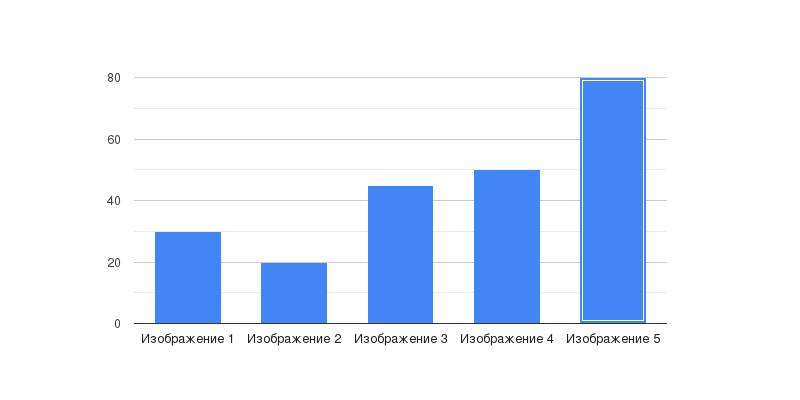

Статистика по методу использованием каскадов Хаара. На оси абсцисс указаны изображения которые анализировались, по оси ординат указано процентное соотношение обнаруженных частиц на изображении.

Обратите внимание, что изображение под номером 5 (с самым высоким показателем), до этого было в выборке при тренировке модели, а также частицы на изображении были в достаточном отдалении друг от друга, вследствие чего можно сделать вывод что данный метод не подходит для решения задачи.

Рассмотрим метод под номером два, с теми же данными:

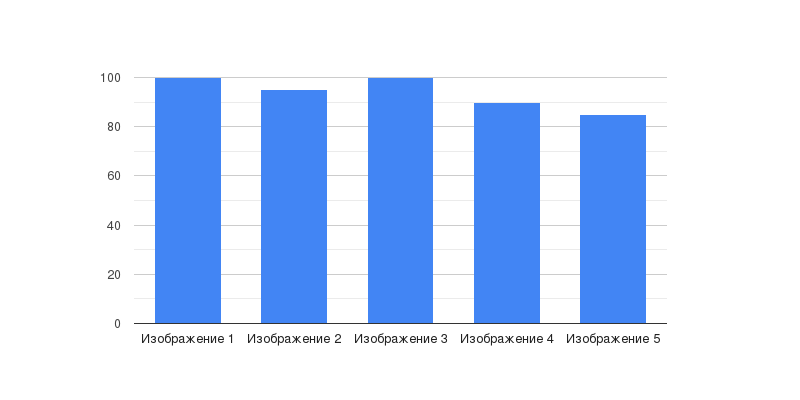

На оси абсцисс указаны изображения которые анализировались, по оси ординат указано процентное соотношение обнаруженных частиц на изображении.

При использовании данного метода средний результат точности определения частиц составляет более 80%, это происходит вследствии того что данный метод определяет тип частиц исключительно по контуру минуя прочие факторы для оценки точности определения, в случае определения формы частиц, пренебрежение прочими параметрами не даёт негативного результата.

Далее будет рассмотрен второй метод.

In [ ]:
# Модуль forms recognition
# Импорт библиотек
import numpy as np
import cv2
import os.path
import math
import squares_math as am

# Функция для поиска частиц


def find_all(find_circles, find_elipses, find_amorphous, find_squares, scale):
    # Проверяем есть ли отфильтрованное изображение
    if os.path.exists('tmp//filter_image.jpg'):
        img = cv2.imread('tmp//filter_image.jpg', cv2.IMREAD_COLOR)  # Чтение изображения
    else:
        img = cv2.imread('tmp//load_image.jpg', cv2.IMREAD_COLOR)  # Чтение изображения

    no_filter_img = cv2.imread('tmp//load_image.jpg')  # Открываем нефильтрованное изображение

    circles_count = 0  # Кол-во найденных круглых частиц
    ellipses_count = 0  # Кол-во найденных эллипсоидных частиц
    triangles_count = 0  # Кол-во найденных треугольных частиц
    squares_count = 0  # Кол-во найденных квадратных частиц
    pentagon_count = 0  # Кол-во найденных пятиугольных частиц
    hexagonal_count = 0  # Кол-во найденных шестиугольных частиц
    heptagon_count = 0  # Кол-во найденных семиугольных частиц
    octagon_count = 0  # Кол-во найденных восьмиугольных частиц
    nonagon_count = 0  # Кол-во найденных девятиугольных частиц
    decagon_count = 0  # Кол-во найденных десятиугольных частиц
    other_count = 0  # Кол-во остальных найденных частиц

    circles_areas = []  # Список площадей круглых частиц
    circles_diameters = []  # Список диаметров круглых частиц

    elipses_areas = []  # Список площадей эллипсоидных частиц
    elipses_diameters = []  # Список диаметров эллипсоидных частиц

    triangles_areas = []  # Список площадей треугольных частиц
    squares_areas = []  # Список площадей квадратных частиц
    pentagon_areas = []  # Список площадей пятиугольных форм
    hexagonal_areas = []  # Список площадей шестиугольных форм
    heptagon_areas = []  # Список площадей семиугольных форм
    octagon_areas = []  # Список площадей восьмиугольных форм
    nonagon_areas = []  # Список площадей девятиугольных форм
    decagon_areas = []  # Список площадей десятиугольных форм
    other_areas = []  # Список площадей остальных частиц

    # Если нужно найти круглые частицы

    if find_circles:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Конвертация в чёрно-белый цвет

        gray_blurred = cv2.blur(gray, (3, 3))  # Размытие изображения

        param1 = 50
        param2 = 30
        minRadius = 10  # Минимальный радиус частицы
        maxRadius = 100  # Максимальный радиус частицы

        detected_circles = cv2.HoughCircles(gray_blurred, cv2.HOUGH_GRADIENT, 1, 30, param1=param1,
                                            param2=param2, minRadius=minRadius,
                                            maxRadius=maxRadius)  # Ищем круги на изображении через преобразование хафа

        # Если круги найдены
        if detected_circles is not None:
            detected_circles = np.uint16(np.around(detected_circles))  # Конвертируем параметры в uint16

            for pt in detected_circles[0, :]:
                a, b, r = pt[0], pt[1], pt[2]

                area = math.pi * (r*r)  # Получаем площадь круга через радиус
                area = area * scale  # Умножаем площадь круга на масштаб изображения
                diameter = (2 * r) * scale  # Получаем диаметр круга через радиус. Умножаем его на масштаб изображения
                circles_areas.append(round(area, 2))  # Добавляем площадь круга в список
                circles_diameters.append(round(diameter, 2))  # Добавляем диаметр круга в список

                # Отмечаем круги на изображении
                cv2.circle(img, (a, b), r, (255, 0, 0), 2)
                cv2.circle(no_filter_img, (a, b), r, (255, 0, 0), 2)

        circles_count = len(str(detected_circles).split("\n"))  # Добавляем полученное кол-во кругов к счётчику

    # Если нужно найти квадраты

    if find_squares:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Конвертация в чёрно-белый цвет

        # Фильтрация изображения
        ret, thresh = cv2.threshold(gray, 50, 255, 0)  # Фильтрация изображения
        contours, hierarchy = cv2.findContours(thresh, 1, 2)  # Находим контуры

        # Отмечаем формы на фото
        for cnt in contours:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  # Аппроксимация контуров
            if len(approx) == 4:  # Если длина списка равна 4
                x, y, w, h = cv2.boundingRect(cnt)  # Получаем длину и высоту
                ratio = float(w) / h  # Получаем соотношение сторон
                if ratio >= 0.9 and ratio <= 1.1:  # Если это квадрат
                    square = (w * h) * scale  # Получаем площадь. Умножаем её на масштаб
                    squares_areas.append(round(square, 2))  # Добавляем площадь в список
                    squares_count += 1  # Добавляем квадрат к счётчику

                    img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отмечаем квадрат на изображении
                    no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отмечаем квадрат на изображении

    if find_elipses:  # Если нужно найти эллипсы
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Переводим изображение в чёрно-белый формат

        ret, thresh = cv2.threshold(gray, 150, 255, 0)  # Фильтруем изображение

        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  # Ищем контуры

        for cnt in contours:  # Цикл для обработки контуров
            try:
                approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
                if len(approx) <= 12:
                    if len(approx) == 4:  # Если у фигуры 4 угла. Пропускаем
                        continue
                    elif len(approx) == 3:  # Если у фигуры 3 угла. Пропускаем
                        continue
                    elif len(approx) == 5:  # Если у фигуры 5 углов. Пропускаем
                        continue
                    elif len(approx) == 6:  # Если у фигуры 6 углов. Пропускаем
                        continue
                    elif len(approx) == 8: # Если у фигуры 8 углов. Пропускаем
                        continue
                    if cv2.isContourConvex(approx):
                        ellipses_count += 1  # Добавляем единицу к счётчику эллипсоидных частиц
                        ellipse = cv2.fitEllipse(cnt)
                        orig_x, orig_y, width, height = cv2.boundingRect(cnt)

                        area = (math.pi * ((width * height) / 4)) * scale  # Получаем площадь фигуры
                        diameter = width * scale  # Получаем диаметр фигуры
                        elipses_areas.append(round(area, 2))  # Добавляем площадь в список
                        elipses_diameters.append(round(diameter, 2))  # Добавляем диаметр в список

                        cv2.ellipse(img, ellipse, (255, 0, 0), 3)  # Отмечаем фигуру на изображении
                        cv2.ellipse(no_filter_img, ellipse, (255, 0, 0), 3)  # Отмечаем фигуру на изображении
            except cv2.error:
                pass

    if find_amorphous:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Конвертируем изображение в чёрно-белый цвет
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]  # Фильтруем изображение
        
        # Находим контуры
        cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]

        for cnt in cnts:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)  # Аппроксимация контуров
            if len(approx) == 3:  # Если это треугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем его на масштаб. Округляем
                area = am.triangle_square(perimeter)  # Получаем площадь
                triangles_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                triangles_count += 1  # Добавляем единицу к счётчику треугольников
            elif len(approx) == 4:  # Если это четырёхугольник
                x, y, w, h = cv2.boundingRect(cnt)  # Получаем длину и высоту
                ratio = float(w) / h  # Получаем соотношение сторон
                if ratio >= 0.9 and ratio <= 1.1:
                    pass  # Если это квадрат, ничего не делаем
                else:
                    area = (w * h) * scale  # Получаем площадь. Умножаем её на масштаб
                    squares_areas.append(area)  # Добавляем площадь в список
                    img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                    no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                    squares_count += 1  # Добавляем единицу к счётчику
            elif len(approx) == 5:  # Если это пятиугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.pentagon_area(perimeter)  # Получаем площадь
                pentagon_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                pentagon_count += 1  # Добавляем единицу к счётчику
            elif len(approx) == 6:  # Если это шестиугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.hexagonal_area(perimeter)  # Получаем площадь
                hexagonal_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                hexagonal_count += 1  # Добавляем единицу к счётчику
            elif len(approx) == 7:  # Если это семиугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.heptagon_area(perimeter)  # Получаем площадь
                heptagon_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                heptagon_count += 1  # Добавляем единицу к счётчику
            elif len(approx) == 8:  # Если это восьмиугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.octagon_area(perimeter)  # Получаем площадь
                octagon_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                octagon_count += 1  # Добавляем единицу к счётчику
            elif len(approx) == 9:  # Если это девятиугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.nonagon_area(perimeter)  # Получаем площадь
                nonagon_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                nonagon_count += 1  # Добавляем единицу к счётчику
            elif len(approx) == 10:  # Если это десятиугольник
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.decagon_area(perimeter)  # Получаем площадь
                decagon_areas.append(area)  # Добавляем площадь в список
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отрисовываем контуры на изображении без фильтра
                decagon_count += 1  # Добавляем единицу к счётчику
            else:
                if cv2.isContourConvex(approx):  # Проверяем является частица выпуклой, если да, пропускаем итерацию
                    continue
                img = cv2.drawContours(img, [cnt], -1, (255, 0, 0), 2)  # Иначе отмечаем контуры на изображении
                no_filter_img = cv2.drawContours(no_filter_img, [cnt], -1, (255, 0, 0), 2)  # Отмечаем контуры на изображении без фильтра
                perimeter = cv2.arcLength(cnt, True)  # Получаем периметр
                perimeter = round(perimeter * scale, 2)  # Умножаем периметр на масштаб. Округляем
                area = am.other_area(perimeter, len(approx))  # Получаем площадь
                other_areas.append(round(area, 2))  # Добавляем площадь в список
                other_count += 1  # Добавляем единицу к счётчику

    cv2.imwrite("tmp//out_image.jpg", img)  # Сохраняем отфильтрованное изображение
    cv2.imwrite("tmp//no_filter_out_image.jpg", no_filter_img)  # Сохраняем отфильтрованное изображение

    return circles_count, triangles_count, squares_count, pentagon_count,\
        hexagonal_count, heptagon_count, octagon_count, nonagon_count,\
        decagon_count, ellipses_count, other_count, circles_areas, circles_diameters, \
        elipses_areas, elipses_diameters, triangles_areas, squares_areas, \
        pentagon_areas, hexagonal_areas, heptagon_areas, octagon_areas, \
        nonagon_areas, decagon_areas, other_areas


In [ ]:
# Функция для выбора типа ручного выделения частиц

In [ ]:
def select_manually():
    dpg.delete_item("MAN_SEL_WIN")  # Удаляем окно для избежания ошибки при повторном открытии
    with dpg.window(label="Select Manually", width=200, height=50,
                    no_resize=True, no_collapse=True, modal=True,
                    pos=[(main_width // 2) - 80, (main_height // 2) - 20], tag="MAN_SEL_WIN"):  # Создаём новое окно в центре экрана
        with dpg.group(horizontal=True):  # Создаём группу элементов для их горизонтального расположения
            dpg.add_combo(items=["Circles", "Manually"], default_value="Circles", tag="Combo_MAN_WIN")  # Добавляем выпадающий список в котором можно выбрать выделение круглых или аморфных частиц
            dpg.add_button(label="OK", width=45, callback=hand_select)  # Добавляем кнопку ОК, при нажатии которой вызывается функция hand_select

In [ ]:
# Функция ручного выделения частиц

In [ ]:
def hand_select():
    # Глобализуем основные переменные
    global circles_count, triangles_count, squares_count, pentagon_count, hexagonal_count, \
        heptagon_count, octagon_count, nonagon_count, decagon_count, other_count, circles_tag, amorphous_tag
    selection_type = dpg.get_value("Combo_MAN_WIN")  # Получаем тип частиц которые нужно выделить
    dpg.delete_item("MAN_SEL_WIN")  # Удаляем окно выбора типа частиц

    if selection_type == "Circles":  # Если нужно искать круги
        circles_tag = 0  # Назначаем счётчик для обновления тега элемента в DPG
        radius = 10  # Указываем радиус частицы по умолчанию
        already_click = 0  # Переменная в которой хранится информация о том был ли сделан ранее клик
        while True:
            time.sleep(0.1)  # Пауза 0.1 секунды
            is_click = win32api.GetKeyState(0x01)  # Узнаём нажата ли левая кнопка мыши
            is_pressed_down = win32api.GetKeyState(0x28)  # Узнаём нажата ли кнопка 'Down'
            is_pressed_up = win32api.GetKeyState(0x26)  # Узнаём нажата ли кнопка 'Up'
            is_pressed_enter = win32api.GetKeyState(0x0D)  # Узнаём нажата ли кнопка 'Enter'
            is_pressed_escape = win32api.GetKeyState(0x1B)  # Узнаём нажата ли кнопка 'Escape'
            is_pressed_del = win32api.GetKeyState(0x2E)  # Узнаём нажата ли кнопка 'Delete'
            if is_click < 0:  # Если нажата левая кнопка мыши
                tag = f"Circle_{circles_tag}"  # Назначаем частице тег
                if already_click != 1:  # Если клик сделан впервые создаём элемент
                    dpg.draw_circle((dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]), 25, color=(0, 255, 0),
                                    parent="Image_WIN", tag=tag)
                    already_click = 1  # Указываем что первый клик уже сделан
                else:  # Иначе конфигурируем положение элемента
                    dpg.configure_item(tag, center=(dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]))
            if is_pressed_down < 0:  # Если нажата клавиша 'Down' уменьшаем радиус на единицу
                radius -= 1
                dpg.configure_item(tag, radius=radius)
            if is_pressed_up < 0:  # Если нажата клавиша 'Up' увеличиваем радиус на единицу
                radius += 1
                dpg.configure_item(tag, radius=radius)
            if is_pressed_enter < 0:  # Если нажата клавиша 'Enter'
                already_click = 0  # Сбрасываем счётчик кликов
                circles_tag += 1  # Прибавляем единицу к тегу
                circles_count += 1  # Прибавляем единицу к счётчику круглых частиц

                stat_pos = dpg.get_item_pos("Statistic")  # Получаем положение окна со статистикой

                dpg.delete_item("Statistic")  # Удаляем окно со статистикой

                statistic_win(stat_pos)  # Создаём его заново (для обновления данных)

                area = (math.pi * (radius * radius)) * scale_size  # Получаем площадь круга
                diameter = (2 * radius) * scale_size  # Получаем диаметр круга

                circles_areas.append(round(area, 2))  # Добавляем площадь в список
                circles_diameters.append(round(diameter, 2))  # Добавляем диаметр в список
                time.sleep(1)  # Ждеём одну секунду
            if is_pressed_escape < 0:  # Если нажата клавиша 'Escape'
                if already_click != 0:  # Если уже сделан, но элемент не сохранён, удаляем его и завершаем работу функции
                    dpg.delete_item(tag)
                return

            if is_pressed_del < 0:  # Если нажата клавиша 'Del' удаляем элемент
                dpg.delete_item(tag)
                already_click = 0
    else:  # Если выбрано аморфное выделение
        amorphous_tag = 0  # Счётчик для тега
        already_click = 0  # Переменная в которой хранится информация о том был ли сделан ранее клик
        lines = []  # Список в котором хранятся длины линий

        while True:
            is_click = win32api.GetKeyState(0x01)  # Узнаём нажата ли левая кнопка мыши
            is_pressed_enter = win32api.GetKeyState(0x0D)  # Узнаём нажата ли клавиша 'Enter'
            is_pressed_escape = win32api.GetKeyState(0x1B)  # Узнаём нажата ли клавиша 'Escape'
            is_click_right = win32api.GetKeyState(0x02)  # Узанём нажата ли правая кнопка мыши
            is_pressed_del = win32api.GetKeyState(0x2E)  # Узнаём нажата ли клавиша 'Del'

            if is_click_right < 0:  # Если нажата правая кнопка мыши
                already_click = 0  # Присваиваем переменной already_click значение 0
                amorphous_tag += 1  # Обновляем тег
                if line_height != 0 and line_width != 0:  # Если длина или высота линии не равна 0 добавляем самое большое значение в список линий
                    lines.append(max(line_height, line_width))
                line_height = 0  # Присваиваем высоте линии 0
                line_width = 0  # Присваиваем длине линии 0

            if is_pressed_del < 0:  # Если нажата клавиша 'Del'
                dpg.delete_item(tag)  # Удаляем линию
                already_click = 0  # Присваиваем переменной already_click значение 0

            if is_click < 0:  # Если нажата левая кнопка мыши
                tag = f"Amorphous_{amorphous_tag}"  # Обновляем тег
                if already_click == 0:  # Если already_click равна 0
                    dpg.draw_line((100, 60), (50, 60), color=(255, 0, 0, 255), parent="Image_WIN", tag=tag)  # Рисуем новую линию
                    already_click = 1  # Присваиваем переменной already_click значение 1
                    dpg.configure_item(tag, p1=(dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]),
                                       p2=(dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]), parent="Image_WIN")  # Обновляем положение линии
                    last_pos = dpg.get_mouse_pos()[0]  # Запоминаем последнюю позицию
                    last_pos_2 = dpg.get_mouse_pos()[1]  # Запоминаем последнюю позицию
                else:
                    line_width = dpg.get_mouse_pos()[0] - last_pos  # Получаем длину линии
                    line_height = dpg.get_mouse_pos()[1] - last_pos_2  # Получаем высоту линии
                    if line_width < 0:  # Если у длины отрицательное значение
                        line_width = -line_width  # Преобразуем в положительное
                    if line_height < 0:  # Если у высоты отрицательное значение
                        line_height = -line_height  # Преобразуем в положительное
                    dpg.configure_item(tag, p1=(last_pos, last_pos_2),
                                       p2=(dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]), parent="Image_WIN")  # Конфигурируем положение элемента
            if is_pressed_enter < 0:  # Если нажата клавиша 'Enter'
                if len(lines) == 3:  # Если это треугольник
                    area = sm.triangle_square(sum(lines)) * scale_size  # Получаем площадь
                    triangles_areas.append(round(area, 2))  # Добавляем в список
                    triangles_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 4:  # Если это четырёхугольник\квадрат
                    area = sm.square_area(lines[0], lines[1], lines[2], lines[3]) * scale_size  # Получаем площадь
                    squares_diameters.append(round(area, 2))  # Добавляем в список
                    squares_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 5:  # Если это пятиугольник
                    area = sm.pentagon_area(sum(lines)) * scale_size  # Получаем площадь
                    pentagon_areas.append(round(area, 2))  # Добавляем в список
                    pentagon_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 6:  # Если это шестиугольник
                    area = sm.hexagonal_area(sum(lines)) * scale_size  # Получаем площадь
                    hexagonal_areas.append(round(area, 2))  # Добавляем в список
                    hexagonal_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 7:  # Если это семиугольник
                    area = sm.heptagon_area(sum(lines)) * scale_size  # Получаем площадь
                    heptagon_areas.append(round(area, 2))  # Добавляем в список
                    heptagon_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 8:  # Если это восьмиугольник
                    area = sm.octagon_area(sum(lines)) * scale_size  # Получаем площадь
                    octagon_areas.append(round(area, 2))  # Добавляем в список
                    octagon_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 9:  # Если это девятиугольник
                    area = sm.nonagon_area(sum(lines)) * scale_size  # Получаем площадь
                    nonagon_areas.append(round(area, 2))  # Добавляем в список
                    nonagon_count += 1  # Прибавляем к счётчику единицу
                elif len(lines) == 10:  # Если это десятиугольник
                    area = sm.decagon_area(sum(lines)) * scale_size  # Получаем площадь
                    decagon_areas.append(round(area, 2))  # Добавляем в список
                    decagon_count += 1  # Прибавляем к счётчику единицу
                else:  # Если это другая частица
                    area = sm.other_area(sum(lines), len(lines)) * scale_size  # Получаем площадь
                    other_areas.append(round(area, 2))  # Добавляем в список
                    other_count += 1  # Прибавляем к счётчику единицу

                time.sleep(1)  # Ожидаем одну секунду
                lines = []  # Обнуляем список
                pos = dpg.get_item_pos("Statistic")  # Получаем позицию окна со статистикой
                statistic_win(pos)  # Обновляем статистику

            if is_pressed_escape < 0:  # Если нажата клавиша 'Escape'
                if already_click != 0:  # Если уже нарисована линия, удаляем её и завершаем работу функции
                    dpg.delete_item(tag)
                return

In [ ]:
# Функция для построения таблицы со списком частиц

In [ ]:
def table_win():
    try:
        pos = dpg.get_item_pos("Table_WIN")  # Получаем последнюю позицию окна
        width = dpg.get_item_width("Table_WIN")  # Получаем последнюю длину окна
        height = dpg.get_item_height("Table_WIN")  # Получаем последнюю выосту окна
    except Exception as err:
        pos = (0, 0)  # В случае ошибки, устанавливаем положение по умолчание
        width = 600  # Устанавливаем длину по умолчанию
        height = 50  # Устанавливаем высоту по умолчанию
    dpg.delete_item("Table_WIN")  # Удаляем окно, для избежания ошибки при повторном открытии
    with dpg.window(tag="Table_WIN", label="Table", width=width, height=height, pos=pos):  # Создаём окно
        with dpg.table(header_row=True, row_background=True):  # Создаём таблицу
            dpg.add_table_column(label="Number")  # Добавляем колонку с номером
            dpg.add_table_column(label="Type")  # Добавляем колонку с типом
            dpg.add_table_column(label="Diameter")  # Добавляем колонку с диаметром
            dpg.add_table_column(label="Area")  # Добавляем колонку с площадью

            particles_num = 0  # Счётчик номера частиц

            for index, circle in enumerate(sorted(circles_areas)):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text("Circle", color=(0, 0, 255))  # Добавляем ячейку с типом частицы
                    dpg.add_text(f'{circles_diameters[index]} {scale_type}')  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(f'{circle} {scale_type}')  # Добавляем ячейку с площадью частицы

            for index, elipse in enumerate(sorted(elipses_areas)):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text("Ellipse", color=(0, 255, 0))  # Добавляем ячейку с типом частицы
                    dpg.add_text(f'{elipses_diameters[index]} {scale_type}')  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(f'{elipse} {scale_type}')  # Добавляем ячейку с площадью частицы

            for triangle in sorted(triangles_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Triangle"), color=(252, 245, 199))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{triangle} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for square in sorted(squares_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Square"), color=(255, 0, 0))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{square} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for pentagon in sorted(pentagon_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Pentagon"), color=(139, 0, 255))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{pentagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for hexagon in sorted(hexagonal_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Hexagonal"), color=(190, 190, 190))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{hexagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for heptagon in sorted(heptagon_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Heptagon"), color=(5, 208, 255))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{heptagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for octagon in sorted(octagon_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Octagon"), color=(255, 192, 203))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{octagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for nonagon in sorted(nonagon_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Nonagon"), color=(255, 92, 5))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{nonagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for decagon in sorted(decagon_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Decagon"), color=(85, 104, 50))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{decagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for other in sorted(other_areas):  # Сортриуем список, проходим по нему циклом
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Other"), color=(255, 255, 0))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{other} {scale_type}'))  # Добавляем ячейку с площадью частицы

        with dpg.group(horizontal=True):  # Создаём группу элементов, для их расположения по горизонтали
            dpg.add_button(label="Build Graph", callback=build_graph)  # Создаём кнопку для построения графика
            dpg.add_button(label="Reset", callback=reset_table_win)  # Создаём кнопку для сброса сортировки
            dpg.add_button(label="Save as Excel file", callback=graph_to_xlsx)  # Создаём кнопку для сохранения данных в Excel файл


In [ ]:
# Функция сброса сортировки в таблице

In [ ]:
def reset_table_win():
    pos = dpg.get_item_pos("Table_WIN")  # Получаем позицию окна
    width = dpg.get_item_width("Table_WIN")  # Получаем длину окна
    height = dpg.get_item_height("Table_WIN")  # Получаем высоту окна
    dpg.delete_item("Table_WIN")  # Удаляем окно
    
    with dpg.window(tag="Table_WIN", label="Table", width=width, height=height, pos=pos):  # Создаём окно повторно
        with dpg.table(header_row=True, row_background=True):  # Создаём таблицу
            dpg.add_table_column(label="Number")  # Добавляем колонку с номером
            dpg.add_table_column(label="Type")  # Добавляем колонку с типом
            dpg.add_table_column(label="Diameter")  # Добавляем колонку с диаметром
            dpg.add_table_column(label="Area")  # Добавляем колонку с площадью

            particles_num = 0  # Счётчик номера частиц

            for index, circle in enumerate(circles_areas):  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text("Circle", color=(0, 0, 255))  # Добавляем ячейку с типом частицы
                    dpg.add_text(f'{circles_diameters[index]} {scale_type}')  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(f'{circle} {scale_type}')  # Добавляем ячейку с площадью частицы

            for index, elipse in enumerate(elipses_areas):  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text("Ellipse", color=(0, 255, 0))  # Добавляем ячейку с типом частицы
                    dpg.add_text(f'{elipses_diameters[index]} {scale_type}')  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(f'{elipse} {scale_type}')  # Добавляем ячейку с площадью частицы

            for triangle in triangles_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Triangle"), color=(252, 245, 199))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{triangle} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for square in squares_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Square"), color=(255, 0, 0))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{square} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for pentagon in pentagon_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Pentagon"), color=(139, 0, 255))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{pentagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for hexagon in hexagonal_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Hexagonal"), color=(190, 190, 190))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{hexagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for heptagon in heptagon_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Heptagon"), color=(5, 208, 255))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{heptagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for octagon in octagon_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Octagon"), color=(255, 192, 203))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{octagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for nonagon in nonagon_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Nonagon"), color=(255, 92, 5))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{nonagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for decagon in decagon_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Decagon"), color=(85, 104, 50))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{decagon} {scale_type}'))  # Добавляем ячейку с площадью частицы

            for other in other_areas:  # Проходим циклом по списку, не сортируя его
                particles_num += 1  # Прибавляем единицу к счётчику
                with dpg.table_row():  # Добавляем строку в таблицу
                    dpg.add_text(str(particles_num))  # Добавляем ячейку с номером частицы
                    dpg.add_text(str("Other"), color=(255, 255, 0))  # Добавляем ячейку с типом частицы
                    dpg.add_text(str("None"))  # Добавляем ячейку с диаметром частицы
                    dpg.add_text(str(f'{other} {scale_type}'))  # Добавляем ячейку с площадью частицы

        with dpg.group(horizontal=True):  # Создаём группу элементов, для их расположения по горизонтали
            dpg.add_button(label="Build Graph", callback=build_graph)  # Создаём кнопку для построения графика
            dpg.add_button(label="Sorted", callback=table_win)  # Создаём кнопку для сортировки
            dpg.add_button(label="Save as Excel file", callback=graph_to_xlsx)  # Создаём кнопку для сохранения данных в Excel файл


In [ ]:
# Функция для создания окна со статистикой

In [ ]:
def statistic_win(pos):
    dpg.delete_item("Statistic")  # Удаляем окно, для избежания ошибки при повторном открытии

    with dpg.window(tag="Statistic", label="Statistic", width=win_width, height=50,
                    pos=pos, no_close=True):  # Создаём окно повторно
        with dpg.table(header_row=True):  # Создаём таблицу
            if circles_count > 0:
                dpg.add_table_column(label="Circles")  # Если кол-во кругов больше нуля добавляем столбец
            if elipses_count > 0:
                dpg.add_table_column(label="Ellipse")  # Если кол-во эллипсов больше нуля добавляем столбец
            if squares_count > 0:
                dpg.add_table_column(label="Squares")  # Если кол-во квадратов больше нуля добавляем столбец
            if triangles_count > 0:
                dpg.add_table_column(label="Triangles")  # Если кол-во треугольников больше нуля добавляем столбец
            if pentagon_count > 0:
                dpg.add_table_column(label="Pentagons")  # Если кол-во пятиугольников больше нуля добавляем столбец
            if hexagonal_count > 0:
                dpg.add_table_column(label="Hexagonals")  # Если кол-во шестиугольников больше нуля добавляем столбец
            if heptagon_count > 0:
                dpg.add_table_column(label="Heptagonals")  # Если кол-во семиугольников больше нуля добавляем столбец
            if octagon_count > 0:
                dpg.add_table_column(label="Octagons")  # Если кол-во восьмиугольнкиов больше нуля добавляем столбец
            if nonagon_count > 0:
                dpg.add_table_column(label="Nonagons")  # Если кол-во девятиугольников больше нуля добавляем столбец
            if decagon_count > 0:
                dpg.add_table_column(label="Decagons")  # Если кол-во десятиугольнкиов больше нуля добавляем столбец
            if other_count > 0:
                dpg.add_table_column(label="Other")  # Если кол-во других частиц больше нуля добавляем столбец

            with dpg.table_row():
                if circles_count > 0:
                    dpg.add_text(str(circles_count), tag="circles_stat")  # Если кол-во кругов больше нуля добавляем строку
                if elipses_count > 0:
                    dpg.add_text(str(elipses_count), tag="elipses_stat")  # Если кол-во эллипсов больше нуля добавляем строку
                if triangles_count > 0:
                    dpg.add_text(str(triangles_count), tag="triangles_stat")  # Если кол-во треугольников больше нуля добавляем строку
                if squares_count > 0:
                    dpg.add_text(str(squares_count), tag="squares_stat")  # Если кол-во квадратов больше нуля добавляем строку
                if pentagon_count > 0:
                    dpg.add_text(str(pentagon_count), tag="pentagon_stat")  # Если кол-во пятиугольников больше нуля добавляем строку
                if hexagonal_count > 0:
                    dpg.add_text(str(hexagonal_count), tag="hexagonal_stat")  # Если кол-во шестиугольников больше нуля добавляем строку
                if heptagon_count > 0:
                    dpg.add_text(str(heptagon_count), tag="heptagon_stat")  # Если кол-во семиугольников больше нуля добавляем строку
                if octagon_count > 0:
                    dpg.add_text(str(octagon_count), tag="octagon_stat")  # Если кол-во восьмиугольников больше нуля добавляем строку
                if nonagon_count > 0:
                    dpg.add_text(str(nonagon_count), tag="nonagon_stat")  # Если кол-во девятиугольнкиов больше нуля добавляем строку
                if decagon_count > 0:
                    dpg.add_text(str(decagon_count), tag="decagon_stat")  # Если кол-во десятиугольников больше нуля добавляем строку
                if other_count > 0:
                    dpg.add_text(str(other_count), tag="other_stat")  # Если кол-во других частиц больше нуля добавляем строку

In [ ]:
# Функция для вычисления процентного соотношения

In [ ]:
def get_percent(a, b):
    try:
        percent = round(float(int(b) / int(a) * 100), 2)  # Получаем процентное соотношение через формулу
    except ZeroDivisionError:  # В случае ошибки при делении на 0, указываем нулевой процент
        percent = 0
    return percent

In [ ]:
# Функция построения графика

In [ ]:
def build_graph():
    global img_size  # Делаем переменную img_size глобальной
    areas = []  # Создаём список в котором будут хранится площади фигур
    percents = []  # Создаём список в котором будут хранится соотношения масштаба фигур с масштабом изображения
    img_size = img_size * scale_size  # Получаем масштаб изображения

    for square in squares_areas:  # Циклом проходим по всем квадратным частицам
        areas.append(square)  # Добавляем площадь в список
        percents.append(get_percent(img_size, square))  # Получаем процентное соотношение. Добавляем его в список
        
    for circle in circles_areas:  # Циклом проходим по всем круглым частицам
        areas.append(circle)  # Добавляем площадь в список
        percents.append(get_percent(img_size, circle))  # Получаем процентное соотношение. Добавляем его в список

    for elipse in elipses_areas:  # Циклом проходим по всем эллипсоидным частицам
        areas.append(elipse)  # Добавляем площадь в список
        percents.append(get_percent(img_size, elipse))  # Получаем процентное соотношение. Добавляем его в список

    for triangle in triangles_areas:  # Циклом проходим по всем треугольным частицам
        areas.append(triangle)  # Добавляем площадь в список
        percents.append(get_percent(img_size, triangle))  # Получаем процентное соотношение. Добавляем его в список

    for pentagon in pentagon_areas:  # Циклом проходим по всем пятиугольным частицам
        areas.append(pentagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, pentagon))  # Получаем процентное соотношение. Добавляем его в список

    for hexagonal in hexagonal_areas:  # Циклом проходим по всем шестиугольным частицам
        areas.append(hexagonal)  # Добавляем площадь в список
        percents.append(get_percent(img_size, hexagonal))  # Получаем процентное соотношение. Добавляем его в список

    for heptagon in heptagon_areas:  # Циклом проходим по всем семиугольным частицам
        areas.append(heptagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, heptagon))  # Получаем процентное соотношение. Добавляем его в список

    for octagon in octagon_areas:  # Циклом проходим по всем восьмиугольным частицам
        areas.append(octagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, octagon))  # Получаем процентное соотношение. Добавляем его в список

    for nonagon in nonagon_areas:  # Циклом проходим по всем девятиугольным частицам
        areas.append(nonagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, nonagon))  # Получаем процентное соотношение. Добавляем его в список

    for decagon in decagon_areas:  # Циклом проходим по всем десятиугольным частицам
        areas.append(decagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, decagon))  # Получаем процентное соотношение. Добавляем его в список

    for other in other_areas:  # Циклом проходим по всем остальным частицам
        areas.append(other)  # Добавляем площадь в список
        percents.append(get_percent(img_size, other))  # Получаем процентное соотношение. Добавляем его в список

    # Удаляем график, для избежания ошибки при повторном открытии окна
    dpg.delete_item("Graph")
    dpg.delete_item("plot")
    dpg.delete_item("plot_theme")
    
    with dpg.window(label="Graph", width=500, height=400, tag="Graph"):  # Создаём окно графика
        # Устанавливаем тему графика
        with dpg.theme(tag="plot_theme"):
            with dpg.theme_component(dpg.mvStemSeries):
                dpg.add_theme_color(dpg.mvPlotCol_Line, (150, 255, 0), category=dpg.mvThemeCat_Plots)
                dpg.add_theme_style(dpg.mvPlotStyleVar_Marker, dpg.mvPlotMarker_Circle, category=dpg.mvThemeCat_Plots)
                dpg.add_theme_style(dpg.mvPlotStyleVar_MarkerSize, 4, category=dpg.mvThemeCat_Plots)

            with dpg.theme_component(dpg.mvStemSeries):
                dpg.add_theme_color(dpg.mvPlotCol_Line, (150, 255, 0), category=dpg.mvThemeCat_Plots)
                dpg.add_theme_style(dpg.mvPlotStyleVar_Marker, dpg.mvPlotMarker_Circle, category=dpg.mvThemeCat_Plots)
                dpg.add_theme_style(dpg.mvPlotStyleVar_MarkerSize, 4, category=dpg.mvThemeCat_Plots)

        # Создаём график
        with dpg.plot(tag="plot", height=-1, width=-1):
            dpg.add_plot_legend()

            dpg.add_plot_axis(dpg.mvXAxis, label="Squares")  # Добавляем подпись для оси абсцисс
            dpg.add_plot_axis(dpg.mvYAxis, label="Percent, %", tag="yaxis")  # Добавляем подпись для оси ординат

            dpg.add_scatter_series(areas, percents, parent="yaxis", tag="graph_data")  # Добавляем данные из соответствующих списокв

            dpg.bind_item_theme("graph_data", "plot_theme")  # Устанавливаем тему


In [ ]:
# Функция для сохранения данных в Excel файл

In [ ]:
def graph_to_xlsx():
    global img_size  # Делаем переменную img_size глобальной
    areas = []  # Создаём список в котором будут хранится площади фигур
    percents = []  # Создаём список в котором будут хранится соотношения масштаба фигур с масштабом изображения
    img_size = img_size * scale_size  # Получаем масштаб изображения

    for square in squares_areas:  # Циклом проходим по всем квадратным частицам
        areas.append(square)  # Добавляем площадь в список
        percents.append(get_percent(img_size, square))  # Получаем процентное соотношение. Добавляем его в список
        
    for circle in circles_areas:  # Циклом проходим по всем круглым частицам
        areas.append(circle)  # Добавляем площадь в список
        percents.append(get_percent(img_size, circle))  # Получаем процентное соотношение. Добавляем его в список

    for elipse in elipses_areas:  # Циклом проходим по всем эллипсоидным частицам
        areas.append(elipse)  # Добавляем площадь в список
        percents.append(get_percent(img_size, elipse))  # Получаем процентное соотношение. Добавляем его в список

    for triangle in triangles_areas:  # Циклом проходим по всем треугольным частицам
        areas.append(triangle)  # Добавляем площадь в список
        percents.append(get_percent(img_size, triangle))  # Получаем процентное соотношение. Добавляем его в список

    for pentagon in pentagon_areas:  # Циклом проходим по всем пятиугольным частицам
        areas.append(pentagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, pentagon))  # Получаем процентное соотношение. Добавляем его в список

    for hexagonal in hexagonal_areas:  # Циклом проходим по всем шестиугольным частицам
        areas.append(hexagonal)  # Добавляем площадь в список
        percents.append(get_percent(img_size, hexagonal))  # Получаем процентное соотношение. Добавляем его в список

    for heptagon in heptagon_areas:  # Циклом проходим по всем семиугольным частицам
        areas.append(heptagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, heptagon))  # Получаем процентное соотношение. Добавляем его в список

    for octagon in octagon_areas:  # Циклом проходим по всем восьмиугольным частицам
        areas.append(octagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, octagon))  # Получаем процентное соотношение. Добавляем его в список

    for nonagon in nonagon_areas:  # Циклом проходим по всем девятиугольным частицам
        areas.append(nonagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, nonagon))  # Получаем процентное соотношение. Добавляем его в список

    for decagon in decagon_areas:  # Циклом проходим по всем десятиугольным частицам
        areas.append(decagon)  # Добавляем площадь в список
        percents.append(get_percent(img_size, decagon))  # Получаем процентное соотношение. Добавляем его в список

    for other in other_areas:  # Циклом проходим по всем остальным частицам
        areas.append(other)  # Добавляем площадь в список
        percents.append(get_percent(img_size, other))  # Получаем процентное соотношение. Добавляем его в список
    
    # Создаём диалоговое окно для сохранения
    path_to_save = filedialog.asksaveasfilename(defaultextension=".xlsx", filetypes=[("Книга Excel 97-2003", ".xls"), ("Книга Excel", ".xlsx")])

    df = pd.DataFrame({'Площадь': areas,
                       'Процент': percents})  # Создаём DataFrame в Pandas

    df.to_excel(path_to_save)  # Сохраняем файл по пути указаному в диалоговом окне

In [ ]:
# Функция для создания диалогового окна с подсказкой при выделении масштаба

In [ ]:
def find_scale():
    dpg.delete_item("Set Scale")  # Удаляем окно для избежания ошибки при повторном открытии
    with dpg.window(label="Set Scale", width=200, height=50,
                    no_resize=True, no_collapse=True, modal=True, tag="Set Scale",
                    pos=[(main_width // 2) - 80, (main_height // 2) - 20]):  # Создаём окно в центре экрана
        dpg.add_text(default_value="Select scale with\nleft button of mouse\nand then press ENTER")  # Создаём текст с подсказкой
        dpg.add_button(label="OK", width=45, callback=close_scale_win)  # Создаём кнопку 'OK', которая вызовет функцию выделения масштаба

In [ ]:
# Функция закрытия диалогового окна с подсказкой при выделении масштаба

In [ ]:
def close_scale_win():
    dpg.delete_item("Set Scale")  # Закрываем окно с подсказкой
    Thread(target=wait_highlight).start()  # Создаём поток для выделения масштаба

In [ ]:
# Функция для выделения масштаба изображения

In [ ]:
def wait_highlight():
    global scale_px  # Делаем переменную scale_px глобальной
    is_click = 0  # Нажата ли кнопка левая кнопка мыши ранее
    
    while True:  # Цикл для ожидания выделения
        is_pressed = win32api.GetKeyState(0x01)  # Если нажата левая кнопка мыши  
        if is_pressed < 0:  # Если ранее она не была нажата
            if is_click == 0:  # Если ранее левая кнопка мыши не нажата
                is_click = 1  # Указываем что кнопка уже нажата
                
                # Получаем последнее положение курсора мыши
                last_pos = dpg.get_mouse_pos()[0] - 5
                last_pos_2 = dpg.get_mouse_pos()[1]
                
                dpg.configure_item("line", p1=(dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]),
                                   p2=(dpg.get_mouse_pos()[0], dpg.get_mouse_pos()[1]))  # Устанавливаем положение линии
                
                dpg.configure_item("line", show=True)  # Делаем линию видимой
            else:
                dpg.configure_item("line", p1=(last_pos, last_pos_2), p2=(dpg.get_mouse_pos()[0], last_pos_2))  # Если левая кнопка мыши была нажата ранее, не меняем положение линии, только увеличиваем длину линии на заданный масштаб
                scale_px = dpg.get_mouse_pos()[0] - last_pos  # Присваиваем переменной масштаба значение длины линии
        else:
            is_pressed_enter = win32api.GetKeyState(0x0D)  # Узнаём нажата ли кнопка 'Enter'
            is_pressed_escape = win32api.GetKeyState(0x1B)  # Узнаём нажата ли кнопка 'Escape'

            if is_pressed_enter < 0:  # Если нажата кнопка 'Enter'
                with dpg.window(label='Enter scale', tag='Enter Scale',
                                no_resize=True, no_collapse=True, modal=True,
                                pos=[(main_width // 2) - 80, (main_height // 2) - 20]):  # Создаём окно для ввода длины линии в дольной единице
                    with dpg.group(horizontal=True):  # Создаём группу элементов, для их горизонтального расположения
                        dpg.add_input_text(tag="Scale_VAL")  # Добавляем поле для ввода длины в дольной единице
                        dpg.add_combo(default_value='nm', items=['nm', 'um', 'mm', 'cm'], tag="Scale_TYPE")  # Добавляем выпадающий список для выбора дольной единицы
                    dpg.add_button(label="OK", callback=close_scale_settings_win)  # Создаём кнопку 'OK', которая закрывает окно
                dpg.configure_item("line", show=False)  # Делем линию снова невидимой
                return  # Завершаем работу функции
            if is_pressed_escape < 0:  # Если нажата клавиша 'Escape'
                dpg.configure_item("line", show=False)  # Делаем линию снова невидимой
                return  # Завершаем работу функции
            is_click = 0

In [ ]:
# Функция закрытия диалогового окна с настройкой масштаба

In [ ]:
def close_scale_settings_win():
    global scale_num, scale_type, scale_size  # Глобализуем переменные
    scale_num = dpg.get_value("Scale_VAL")  # Получаем длину указанную пользвателем
    scale_type = dpg.get_value("Scale_TYPE")  # Получаем тип дольной единицы
    scale_size = float(scale_px) / float(scale_num)  # Получаем размер указанной длины в пикселях
    dpg.delete_item('Enter Scale')  # Закрываем окно настройки

In [ ]:
# Функция сброса выделения частиц

In [ ]:
def reset_highlight():
    global circles_count, elipses_count, squares_count, triangles_count, pentagon_count, \
        hexagonal_count, heptagon_count, octagon_count, nonagon_count, decagon_count, other_count, \
        circles_tag, amorphous_tag  # Глобализуем переменные счётчиков и тегов

    circles_count = 0  # Кол-во найденных круглых частиц
    elipses_count = 0  # Кол-во найденных элипсоидных частиц
    triangles_count = 0  # Кол-во найденных треугольных частиц
    squares_count = 0  # Кол-во найденных квадратных частиц
    pentagon_count = 0  # Кол-во найденных пятиугольных частиц
    hexagonal_count = 0  # Кол-во найденных шестиугольных частиц
    heptagon_count = 0  # Кол-во найденных семиугольных частиц
    octagon_count = 0  # Кол-во найденных восьмиугольных частиц
    nonagon_count = 0  # Кол-во найденных девятиугольных частиц
    decagon_count = 0  # Кол-во найденных десятиугольных частиц
    other_count = 0  # Кол-во остальных найденных частиц

    global circles_diameters, circles_areas, squares_areas, elipses_areas, elipses_diameters, \
        triangles_areas, pentagon_areas, hexagonal_areas, heptagon_areas, octagon_areas, nonagon_areas, \
        decagon_areas, other_areas  # Глобализуем переменные списков диаметров и площадей

    circles_diameters = []  # Список диаметров круглых форм
    circles_squares = []  # Список площадей круглых форм

    elipses_squares = []  # Список площадей эллипсоидных форм
    elipses_diameters = []  # Список диаметров эллипсоидных форм

    triangles_areas = []  # Список площадей треугольных форм
    squares_diameters = []  # Список плошадей квадратных форм
    pentagon_areas = []  # Список площадей пятиугольных форм
    hexagonal_areas = []  # Список площадей шестиугольных форм
    heptagon_areas = []  # Список площадей семиугольных форм
    octagon_areas = []  # Список площадей восьмиугольных форм
    nonagon_areas = []  # Список площадей девятиугольных форм
    decagon_areas = []  # Список площадей десятиугольных форм
    other_areas = []  # Список площадей аморфных форм

    width, height, channels, data = dpg.load_image("tmp//load_image.jpg")  # Открываем старое изображение
    dpg.set_value("texture_tag", data)  # Открываем изображение в окне программы
    dpg.set_value("Image", "texture_tag")  # Открываем изображение в окне программы

    for circle in range(0, circles_tag):  # Циклом проходим по всем тегам круглых частиц
        tag = f"Circle_{circle}"  # Получаем значение тега
        dpg.delete_item(tag)  # Удаляем частицу

    for amorphous in range(0, amorphous_tag):  # Циклом проходим по всем тегам аморфных частиц
        tag = f"Amorphous_{amorphous}"  # Получаем значение тега
        dpg.delete_item(tag)  # Удаляем частицу

    stat_pos = dpg.get_item_pos("Statistic")  # Получаем положение окна со статистикой
    
    # Создаём окно со статистикой повторно, на том же месте, для сброса статистики
    with dpg.window(tag="Statistic", label="Statistic", width=win_width, height=50, pos=stat_pos):
        pass

In [ ]:
# Функция для фильтрации изображения по цветовому диапазону

In [ ]:
def filter_image():
    min_value = dpg.get_value("min_color")  # Получаем минимальное значение цвета
    max_value = dpg.get_value("max_color")  # Получаем максимальное значение цвета
    od.color_filter(min_value, max_value)  # Фильтруем изображение (модуль other_defs)

    width, height, channels, data = dpg.load_image("tmp//filter_image.jpg")  # Загружаем отфильтрованное изображение

    dpg.set_value("texture_tag", data)  # Открываем изображение в окне программы

    dpg.set_value("Image", "texture_tag")  # Открываем изображение в окне программы

In [ ]:
# Функция сброса фильтра по цветовому диапазону

In [ ]:
def reset_image():
    if os.path.exists("tmp//no_filter_out_image.jpg"):
        width, height, channels, data = dpg.load_image("tmp//no_filter_out_image.jpg")  # Открываем старое изображение
    else:
        width, height, channels, data = dpg.load_image("tmp//load_image.jpg")  # Открываем старое изображение
    
    # Открываем изображение в окне программы
    dpg.set_value("texture_tag", data)
    dpg.set_value("Image", "texture_tag")

In [ ]:
# Активация модуля. Запуск главных функций

In [2]:
if __name__ == "__main__":
    gui_init()  # Создаём GUI
    dpg.setup_dearpygui()  # Создаём Viewport
    dpg.show_viewport()  # Выводим Viewport
    dpg.set_primary_window("main_win", True)  # Устанавливаем окно с подсказкой как основное
    dpg.set_viewport_resize_callback(resize_win)  # Устаналвиваем функцию resize_win на действие изменения размера окна
    dpg.start_dearpygui()
    dpg.destroy_context()

<class 'NameError'>: name 'gui_init' is not defined